# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [194]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [195]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [196]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['Fixed Income', 'Private Equity', 'Private Credit', 'Real Estate']

In [197]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [198]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary_v2.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,4/30/2015,2085.51,1938.65,1184.37,989.70,295.33,1890.64
1,5/29/2015,2107.39,1933.98,1190.58,989.64,293.95,1925.25
2,6/30/2015,2063.11,1912.89,1172.35,951.86,279.76,1868.26
3,7/31/2015,2103.84,1926.19,1095.80,930.94,292.92,1972.87
4,8/31/2015,1972.18,1923.42,1134.93,921.65,275.43,1787.97
...,...,...,...,...,...,...,...
116,12/31/2024,5881.63,2189.03,2624.50,1481.10,357.16,5136.31
117,1/31/2025,6040.53,2200.64,2798.41,1530.03,363.90,5386.99
118,2/28/2025,5954.50,2249.06,2857.83,1536.50,377.91,5257.94
119,3/31/2025,5611.85,2249.91,3123.57,1457.69,366.30,4789.93


In [199]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Gold
0,4/30/2015,2085.51,1184.37
1,5/29/2015,2107.39,1190.58
2,6/30/2015,2063.11,1172.35
3,7/31/2015,2103.84,1095.80
4,8/31/2015,1972.18,1134.93
...,...,...,...
116,12/31/2024,5881.63,2624.50
117,1/31/2025,6040.53,2798.41
118,2/28/2025,5954.50,2857.83
119,3/31/2025,5611.85,3123.57


In [200]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12+1
included_rows

49

In [201]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Gold
72,4/30/2021,4181.17,1769.13
73,5/31/2021,4204.11,1906.87
74,6/30/2021,4297.50,1770.11
75,7/30/2021,4395.26,1814.19
76,8/31/2021,4522.68,1813.62
77,9/30/2021,4307.54,1756.95
78,10/29/2021,4605.38,1783.38
79,11/30/2021,4567.00,1774.52
80,12/31/2021,4766.18,1829.20
81,1/31/2022,4515.55,1797.17


In [202]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight', 'Gold Weight']

In [203]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Gold Monthly Return
72,4/30/2021,NaN,NaN
73,5/31/2021,0.005487,0.077857
74,6/30/2021,0.022214,-0.071720
75,7/30/2021,0.022748,0.024902
76,8/31/2021,0.028990,-0.000314
77,9/30/2021,-0.047569,-0.031247
78,10/29/2021,0.069144,0.015043
79,11/30/2021,-0.008334,-0.004968
80,12/31/2021,0.043613,0.030814
81,1/31/2022,-0.052585,-0.017510


In [204]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Gold Monthly Return
73,0.005487,0.077857
74,0.022214,-0.071720
75,0.022748,0.024902
76,0.028990,-0.000314
77,-0.047569,-0.031247
78,0.069144,0.015043
79,-0.008334,-0.004968
80,0.043613,0.030814
81,-0.052585,-0.017510
82,-0.031361,0.062220


In [205]:
#Calculate Avg Monthly Returns and Annualize it (this one is arithmentic)
expected_returns = asset_data_returns.mean() * 12
expected_returns

S&P 500 Monthly Return    0.084745
Gold Monthly Return       0.165608
dtype: float64

In [206]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Gold Monthly Return
S&P 500 Monthly Return,0.026186,0.003487
Gold Monthly Return,0.003487,0.019959


In [207]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((2,), var4111)

In [208]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.08474535, 0.09373003, 0.10271472, 0.11169941, 0.12068409,
       0.12966878, 0.13865347, 0.14763816, 0.15662284, 0.16560753])

In [209]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
        cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
        ]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        annualized_return = expected_returns.values @ weights.value
        annualized_variance = portfolio_variance.value
        efficient_portfolios.append({
            'Weights': weights.value,
            'Return': annualized_return,
            'Variance': annualized_variance
            })

In [210]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[0.4205158413348471, 0.5794841586651529]",0.131604,0.013032,0.114159
6,"[0.33333333333333315, 0.6666666666666669]",0.138653,0.013330,0.115456
7,"[0.2222222222222223, 0.7777777777777777]",0.147638,0.014572,0.120716
8,"[0.11111111111111105, 0.888888888888889]",0.156623,0.016782,0.129546
9,"[1.661964825906535e-09, 1.0000000000395137]",0.165608,0.019959,0.141276


In [211]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Gold Weight (%)
Portfolio 1,13.16,11.42,42.05,57.95
Portfolio 2,13.87,11.55,33.33,66.67
Portfolio 3,14.76,12.07,22.22,77.78
Portfolio 4,15.66,12.95,11.11,88.89
Portfolio 5,16.56,14.13,0.00,100.00


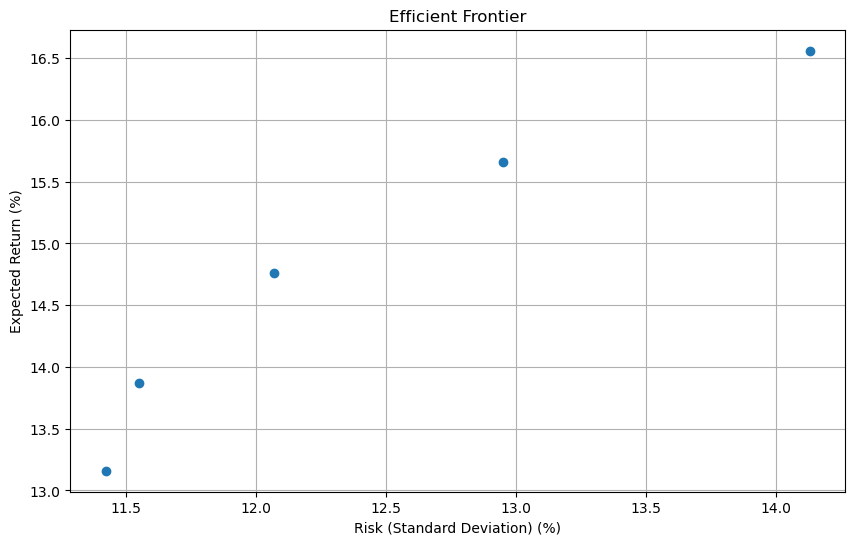

In [212]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()